In [1]:
# Load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from xgboost import XGBClassifier
import torch
import torch.nn as nn

# show a progress bar as your simulations are running
from tqdm import tqdm


%matplotlib inline

## 1. Data Cleaning Process

In [2]:
# Read in bank data

bank_data = pd.read_csv(r'bank-full.csv', sep=';')
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Check missing value -> no missing value
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
# Distribution of numeric variables
bank_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
# Distribution of categorical variables
cat_var = bank_data.columns.drop(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])
for col in cat_var:
    print(bank_data[col].value_counts())
    print('\n')

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64


married     27214
single      12790
divorced     5207
Name: marital, dtype: int64


secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64


no     44396
yes      815
Name: default, dtype: int64


yes    25130
no     20081
Name: housing, dtype: int64


no     37967
yes     7244
Name: loan, dtype: int64


cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64


may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64


unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome

In [6]:
+1 (604) 704-3199# Turn category into numeric (dummy) variables
bank_data1 = pd.get_dummies(bank_data, drop_first=True)
bank_data1.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [7]:
bank_data1.y_yes.value_counts()

0    39922
1     5289
Name: y_yes, dtype: int64

## 2.Data Vistualization

### One dimensional histogram

<AxesSubplot:xlabel='previous', ylabel='Count'>

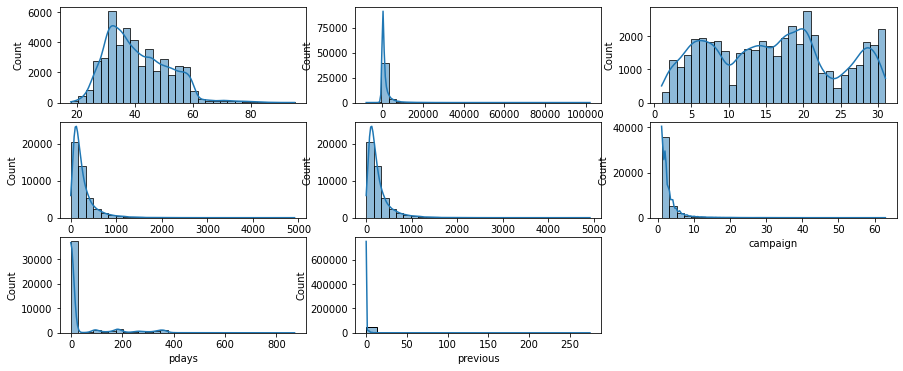

In [8]:
plt.figure(figsize=(15,6))
plt.subplot(3, 3, 1)
sns.histplot(bank_data.age, bins = 30, kde=True)

plt.subplot(3, 3, 2)
sns.histplot(bank_data.balance, bins = 30, kde=True)

plt.subplot(3, 3, 3)
sns.histplot(bank_data.day, bins = 30, kde=True)

plt.subplot(3, 3, 4)
sns.histplot(bank_data.duration, bins = 30, kde=True)

plt.subplot(3, 3, 5)
sns.histplot(bank_data.duration, bins = 30, kde=True)

plt.subplot(3, 3, 6)
sns.histplot(bank_data.campaign, bins = 30, kde=True)

plt.subplot(3, 3, 7)
sns.histplot(bank_data.pdays, bins = 30, kde=True)

plt.subplot(3, 3, 8)
sns.histplot(bank_data.previous, bins = 20, kde=True)

## Two dimensional boxplot

<AxesSubplot:xlabel='y', ylabel='balance'>

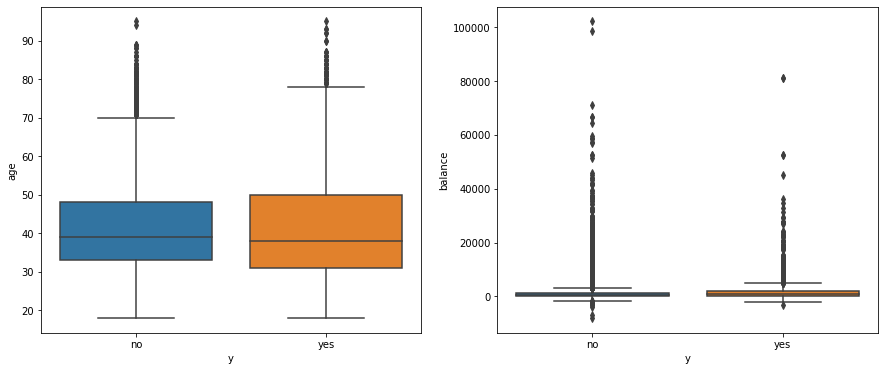

In [9]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.boxplot(x='y', y='age', data=bank_data)

plt.subplot(1, 2, 2)
sns.boxplot(x='y', y='balance', data=bank_data)

<AxesSubplot:xlabel='y', ylabel='duration'>

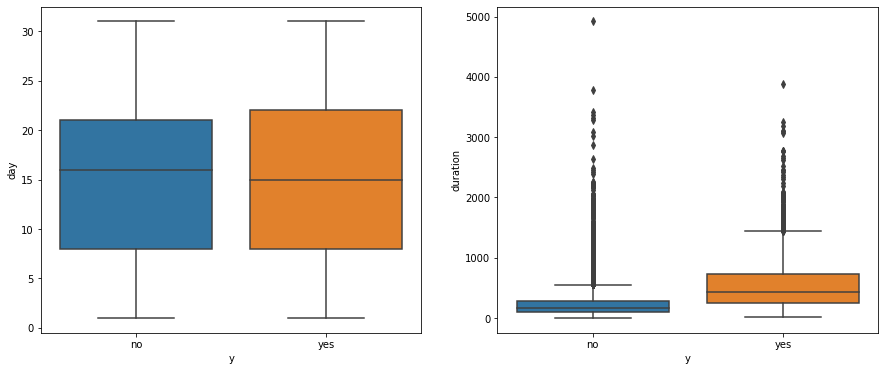

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.boxplot(x='y', y='day', data=bank_data)

plt.subplot(1, 2, 2)
sns.boxplot(x='y', y='duration', data=bank_data)

<AxesSubplot:xlabel='y', ylabel='previous'>

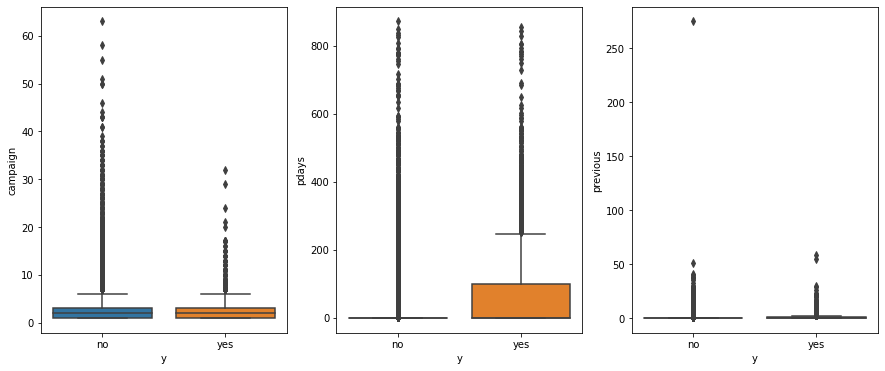

In [11]:
plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
sns.boxplot(x='y', y='campaign', data=bank_data)

plt.subplot(1, 3, 2)
sns.boxplot(x='y', y='pdays', data=bank_data)

plt.subplot(1, 3, 3)
sns.boxplot(x='y', y='previous', data=bank_data)

## 3. Data Splitting

In [12]:
# define X and y
X = bank_data1.drop('y_yes', axis='columns')
y = bank_data1.y_yes

# Split into train & test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(Xtrain.shape, Xtest.shape)

(36168, 42) (9043, 42)


### Check the effect of Standardization -- Balance

Text(0.5, 0, 'After standardization: balance')

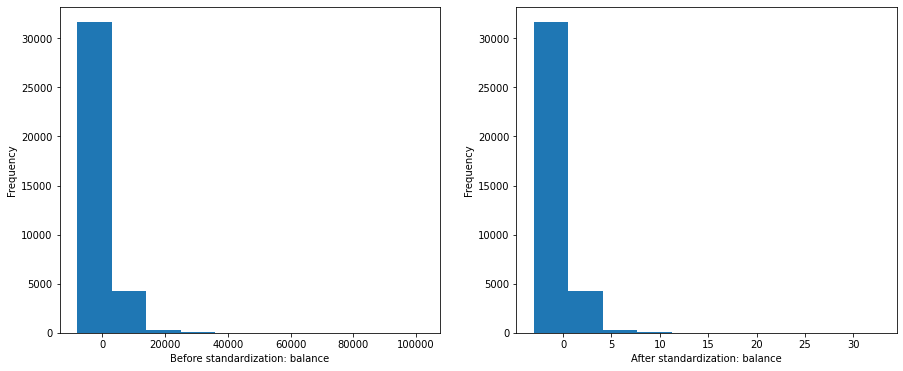

In [13]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_std = scaler.fit_transform(Xtrain)

# Before standardization
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)

plt.hist(Xtrain.balance)
plt.ylabel('Frequency')
plt.xlabel('Before standardization: balance')

# Get the column index of feature "balance"
index = Xtrain.columns.get_loc("balance")

# After standardization
plt.subplot(1, 2, 2)
plt.hist(X_std[:,index])
plt.ylabel('Frequency')
plt.xlabel('After standardization: balance')

### Check the effect of Standardization -- Campaign

Text(0.5, 0, 'After standardization: campaign')

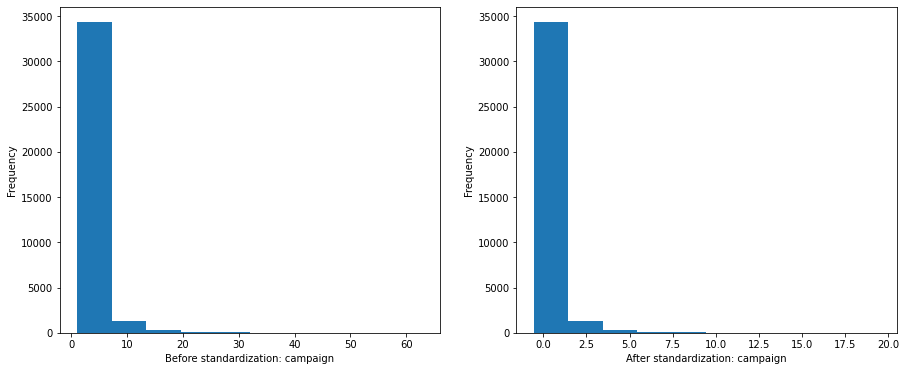

In [14]:
# Before standardization
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)

plt.hist(Xtrain.campaign)
plt.ylabel('Frequency')
plt.xlabel('Before standardization: campaign')

# Get the column index of feature "balance"
index = Xtrain.columns.get_loc("campaign")

# After standardization
plt.subplot(1, 2, 2)
plt.hist(X_std[:,index])
plt.ylabel('Frequency')
plt.xlabel('After standardization: campaign')

## 4. Modelling - Logistic regression

In [15]:
# Obtain baseline accuracy

print(bank_data1.y_yes.value_counts())
baselineacc = 39922 / (39922 + 5289)
print(f"\nBaseline Accuracy: {baselineacc}\n")

0    39922
1     5289
Name: y_yes, dtype: int64

Baseline Accuracy: 0.8830151954170445



In [16]:
model1 = Pipeline([
    ('standardize', StandardScaler()),
    ('Logistic', LogisticRegression())
])

## 5. Modelling - XGboosting

In [17]:
model2 = XGBClassifier(max_depth=10,                 
                        learning_rate=0.1,            
                        n_estimators=300,                              
                        objective='binary:logistic',  
                        booster='gbtree',             
                        n_jobs=4,                     
                        gamma=0.001,                 
                        subsample=0.632,              
                        colsample_bytree=1,           
                        colsample_bylevel=1,         
                        colsample_bynode=1,          
                        reg_alpha=1,                 
                        reg_lambda=0,                 
                        scale_pos_weight=1,                         
                        random_state=100,        
                        missing=None)

## 6. Modelling - Random Forest

In [18]:
# random forest classifier with 3 max feature

model3 = RandomForestClassifier(n_estimators=500, 
                                  min_samples_leaf=0.001,
                                  max_features=3,
                                  min_impurity_decrease=0.0001,
                                  oob_score=True,
                                  n_jobs=4, 
                                  random_state=100,
                                  class_weight='balanced')

## 7. Model Selection based on CV score

In [19]:
# ROC
print(cross_val_score(model1, Xtrain, ytrain, cv=10, scoring='roc_auc').mean())
print(cross_val_score(model2, Xtrain, ytrain, cv=10, scoring='roc_auc').mean())
print(cross_val_score(model3, Xtrain, ytrain, cv=10, scoring='roc_auc').mean())

0.9083396889044145
0.9295137402416493
0.9035012224222031


In [20]:
# recall
print(cross_val_score(model1, Xtrain, ytrain, cv=10, scoring='recall').mean())
print(cross_val_score(model2, Xtrain, ytrain, cv=10, scoring='recall').mean())
print(cross_val_score(model3, Xtrain, ytrain, cv=10, scoring='recall').mean())

0.35022296169316436
0.4929212463446607
0.8192088781329477


In [21]:
# precision
print(cross_val_score(model1, Xtrain, ytrain, cv=10, scoring='precision').mean())
print(cross_val_score(model2, Xtrain, ytrain, cv=10, scoring='precision').mean())
print(cross_val_score(model3, Xtrain, ytrain, cv=10, scoring='precision').mean())

0.6530608439448151
0.6168800938205246
0.3854091113865308


## 8. Test the model performance based on the best model

In [22]:
# Calculate performance measures from scratch
# TP: true postives 
# TN: true negatives 
# FP: False positives 
# FN: False negatives
def compute_performance(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
    
    # Print results
    
    print("Accuracy:",round(acc,3),"\nRecall:",round(recall,3),"\nPrecision:",round(precision,3),
          "\nSensitivity:",round(sensitivity,3),"\nSpecificity:",round(specificity,3))


### XGBoosting

In [23]:
博文# Fit our best performing model on all the training data
model2.fit(Xtrain, ytrain)

# make prediction
ytest_hat2 = model2.predict(Xtest)

compute_performance(ytest_hat2, ytest, model2.classes_)

tp: 502 tn: 7616 fp: 364 fn: 561
Accuracy: 0.898 
Recall: 0.472 
Precision: 0.58 
Sensitivity: 0.472 
Specificity: 0.954


In [24]:
# confusion_matrix
confusion_matrix(ytest, ytest_hat2, labels=[1, 0]).T

array([[ 502,  364],
       [ 561, 7616]])

In [53]:
# adjusting the decision threshold to 0.1
ytest_prob = model2.predict_proba(Xtest)

yhat = model2.classes_[(ytest_prob[:,1] > 0.1).astype(int)]

compute_performance(yhat, ytest, model2.classes_)

tp: 875 tn: 6960 fp: 1020 fn: 188
Accuracy: 0.866 
Recall: 0.823 
Precision: 0.462 
Sensitivity: 0.823 
Specificity: 0.872


0.9241446749517255

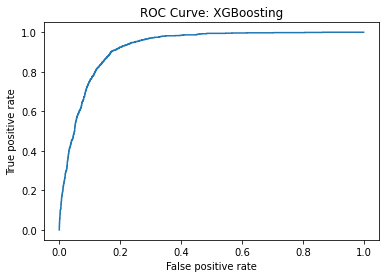

In [26]:
# ROC
ytest_prob = model2.predict_proba(Xtest)
fpr, tpr, _ = roc_curve(ytest, ytest_prob[:,1])
plt.plot(fpr, tpr)
plt.title('ROC Curve: XGBoosting')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

# AUROC
roc_xgb = auc(fpr, tpr)
roc_xgb

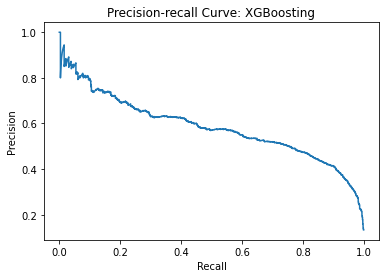

In [27]:
# PRC
ytest_prob = model2.predict_proba(Xtest)
precision, recall, _ = precision_recall_curve(ytest, ytest_prob[:,1])
plt.plot(recall, precision)
plt.title('Precision-recall Curve: XGBoosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Random Forest

In [28]:
# Fit our best performing model on all the training data
model3.fit(Xtrain, ytrain)

# make prediction
ytest_hat3 = model3.predict(Xtest)

compute_performance(ytest_hat3, ytest, model3.classes_)

tp: 856 tn: 6576 fp: 1404 fn: 207
Accuracy: 0.822 
Recall: 0.805 
Precision: 0.379 
Sensitivity: 0.805 
Specificity: 0.824


In [29]:
# confusion_matrix
confusion_matrix(ytest, ytest_hat3, labels=[1, 0]).T

array([[ 856, 1404],
       [ 207, 6576]])

0.8975999500161504

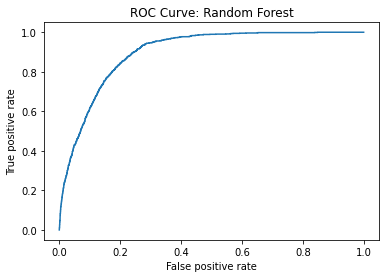

In [30]:
# ROC
ytest_prob = model3.predict_proba(Xtest)
fpr, tpr, _ = roc_curve(ytest, ytest_prob[:,1])
plt.plot(fpr, tpr)
plt.title('ROC Curve: Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

# AUROC
roc_rf = auc(fpr, tpr)
roc_rf

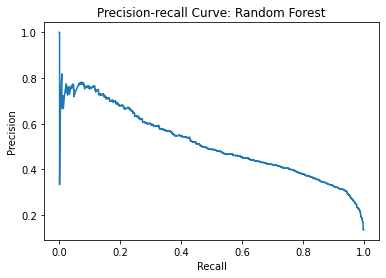

In [31]:
# PRC
ytest_prob = model3.predict_proba(Xtest)
precision, recall, _ = precision_recall_curve(ytest, ytest_prob[:,1])
plt.plot(recall, precision)
plt.title('Precision-recall Curve: Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## 9. Construct CI

### XGBoosting CI

In [50]:
# point estimation
con_mat = confusion_matrix(ytest, yhat, labels=[1, 0]).T
acc = (con_mat[0,0] + con_mat[1,1])/ytest.shape[0]
recall = (con_mat[0,0])/(con_mat[0,0] + con_mat[1,0])
specificity = (con_mat[1,1])/(con_mat[1,1] + con_mat[0,1])
precision = (con_mat[0,0])/(con_mat[0,0] + con_mat[0,1])

# compute the CI
n = ytest.shape[0]
SE = np.sqrt((acc*(1 - acc))/n)
CI = np.array([acc - 1.96*SE, acc + 1.96*SE])
print(f"Accuracy: {acc}")
print(f"95% Confidence interval: {CI} \n")

SE = np.sqrt((recall*(1 - recall))/n)
CI = np.array([recall - 1.96*SE, recall + 1.96*SE])
print(f"Recall: {recall}")
print(f"95% Confidence interval: {CI} \n")

SE = np.sqrt((specificity*(1 - specificity))/n)
CI = np.array([specificity - 1.96*SE, specificity + 1.96*SE])
print(f"Specificity: {specificity}")
print(f"95% Confidence interval: {CI} \n")

SE = np.sqrt((roc_xgb*(1 - roc_xgb))/n)
CI = np.array([roc_xgb - 1.96*SE, roc_xgb + 1.96*SE])
print(f"AUROC: {roc_xgb}")
print(f"95% Confidence interval: {CI} \n")

SE = np.sqrt((precision*(1 - precision))/n)
CI = np.array([precision - 1.96*SE, precision + 1.96*SE])
print(f"Precision: {precision}")
print(f"95% Confidence interval: {CI} \n")

Accuracy: 0.8664160123852703
95% Confidence interval: [0.85940404 0.87342799] 

Recall: 0.8231420507996237
95% Confidence interval: [0.81527794 0.83100616] 

Specificity: 0.8721804511278195
95% Confidence interval: [0.86529866 0.87906224] 

AUROC: 0.9241446749517255
95% Confidence interval: [0.91868756 0.92960179] 

Precision: 0.46174142480211083
95% Confidence interval: [0.45146612 0.47201673] 



### Random Forest CI

In [51]:
# point estimation
con_mat = confusion_matrix(ytest, ytest_hat3, labels=[1, 0]).T
acc = (con_mat[0,0] + con_mat[1,1])/ytest.shape[0]
recall = (con_mat[0,0])/(con_mat[0,0] + con_mat[1,0])
specificity = (con_mat[1,1])/(con_mat[1,1] + con_mat[0,1])
precision = (con_mat[0,0])/(con_mat[0,0] + con_mat[0,1])


# compute the CI
n = ytest.shape[0]
SE = np.sqrt((acc*(1 - acc))/n)
CI = np.array([acc - 1.96*SE, acc + 1.96*SE])
print(f"Accuracy: {acc}")
print(f"95% Confidence interval: {CI} \n")

SE = np.sqrt((recall*(1 - recall))/n)
CI = np.array([recall - 1.96*SE, recall + 1.96*SE])
print(f"Recall: {recall}")
print(f"95% Confidence interval: {CI} \n")

SE = np.sqrt((specificity*(1 - specificity))/n)
CI = np.array([specificity - 1.96*SE, specificity + 1.96*SE])
print(f"Specificity: {specificity}")
print(f"95% Confidence interval: {CI} \n")

SE = np.sqrt((roc_rf*(1 - roc_rf))/n)
CI = np.array([roc_rf - 1.96*SE, roc_rf + 1.96*SE])
print(f"AUROC: {roc_rf}")
print(f"95% Confidence interval: {CI} \n")

SE = np.sqrt((precision*(1 - precision))/n)
CI = np.array([precision - 1.96*SE, precision + 1.96*SE])
print(f"Precision: {precision}")
print(f"95% Confidence interval: {CI} \n")

Accuracy: 0.8218511555899591
95% Confidence interval: [0.81396459 0.82973772] 

Recall: 0.8052681091251176
95% Confidence interval: [0.79710626 0.81342996] 

Specificity: 0.8240601503759398
95% Confidence interval: [0.81621211 0.83190819] 

AUROC: 0.8975999500161504
95% Confidence interval: [0.89135123 0.90384867] 

Precision: 0.3787610619469027
95% Confidence interval: [0.36876309 0.38875903] 



In [39]:
from sklearn.datasets import load_iris
bank_data1.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'y_yes'],
      dtype='object')

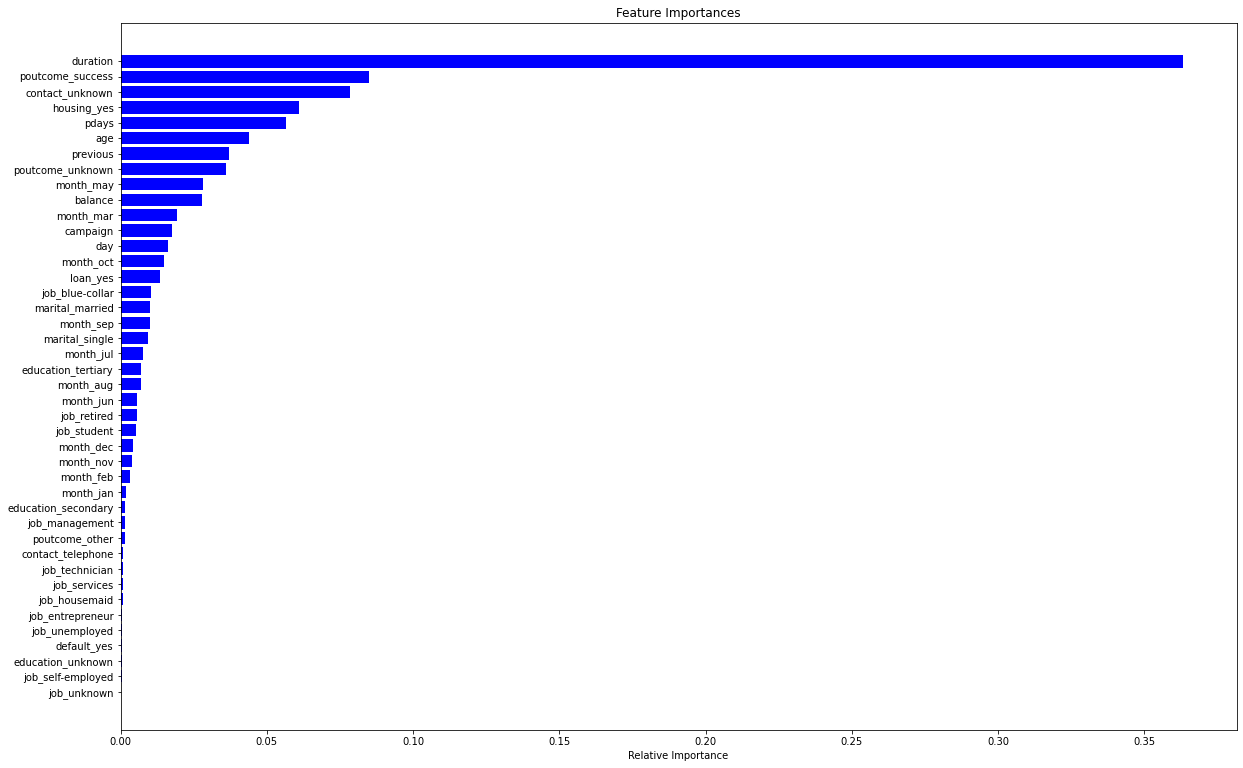

In [49]:
features = bank_data1.columns
importances = model3.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,13))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()